# 1-D Hyperbolic Equations
Recall that the governing equation (in 1D) is:

$$\frac{\partial u}{\partial t}=C\left(\frac{\partial u}{\partial x}\right)$$

As with the parabolic solver we need boundary condition values at _u(x0,t)_ and _u(x1,t)_ and also initial conditions at _u(x,0)_.

We can pretty much use the same class that was used in the parabolic case to store the 1D grid, set the initial conditions and update the boundary conditions. 

To set up the initial condtions we will pass a function _f(x)_ to the function, this will be called inside a loop passing the _x_ orfdinate of evergy grid point.  A similar idea will be used for Dirichlet boundary condtions where a function _f(t)_ will be passed as a parameter.  Here is the code for the initial conditions:

    def initial_conditions(self,fun):
        for i in range(self.N_i):
            self.u[0,i] = fun(self.x[i])

Finally we need to know the time step that can be used.  As we saw in the lectures this is characterised by the CFL condition
$$\Delta t \le \nu \frac{\Delta x}{|C|}$$

The choice of ν depends on the solver being used so we will pass it as a parameter:

    def set_Delta_t(self,Coutrant_number):
        self.Delta_t = Coutrant_number * self.Delta_x()/(2*self.C) 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

def one(t):
    '''simple function of x and t which allways returns 1.0
    This function is used as a place keeper for the 
    Dirichlet boundary condition.'''
    return 1.0


class Grid:
    '''Class defining the grid for a 1D hyperbolic solver.  Solving
    
    $$\frac{\partial u}{\partial t}=C\left(\frac{\partial u}{\partial x}\right)$$

    The grid object contains the number of grid points (Ni), left
    and right ordinates (x0 and x1), flags for wether the boundaries
    are Dirichlet or Neumann boundary conditions and functions for
    plotting the solution both at a particular time level and in the
    form of an x-t plot.  The grid also contains the solution vector (u)
    which is stored as an array with differnt time levels, together with
    the number of time steps N_t and the (uniform) time step Delta_t.
    
    Written by Prof David Ingram, School of Engineering
    (c) 2021 The University of Edinburgh
    Licensed under CC-BY-NC.
    '''
    
    DIRICHLET_BC = 0
    NEUMANN_BC = 1
    PERIODIC_BC = 2

    BC_NAME = ['left', 'right']
    
    def __init__(self,ni):
        # set up information about the grid
        self.x0 = 0.0 #  left
        self.x1 = 1.0 #  right
        self.N_i = ni # grid points in i direction
        self.N_t = 0 # how many time steps have we performed
        self.Delta_t = 0.0 # no dt value yet
        self.C = 1.0 # advection speed (Celarity)

        # initialse x,y and u arrays
        self.u = np.zeros((1,ni))
        self.x = np.zeros(ni)
        self.t = np.zeros(1)

        # boundary conditions (left and right )
        self.BC = [ self.DIRICHLET_BC, self.DIRICHLET_BC ]
        self.BC_fun = [ one, one ]

    def set_x0(self,x0):
        self.x0 = x0
    
    def set_x1(self,x1):
        self.x1 = x1
        
    def set_advection_speed(c):
        self.C = c
        
    def generate(self,Quiet=True):
        '''generate a uniformly spaced grid covering the domain from the
        x0 to the x1.  We are going to do this using linspace from
        numpy to create a list of x ordinates.'''
        self.x = np.linspace(self.x0, self.x1, self.N_i)
        if not Quiet:
            print(self)

    def initial_conditions(self,fun):
        '''set the initial conditions by calling the specified function
        fun(x) at every ordinate'''
        for i in range(self.N_i):
            self.u[0,i] = fun(self.x[i])

    def Delta_x(self):
        # calculate delta x
        return self.x[1]-self.x[0]
    
    def set_Neumann_bc(self,side):
        '''specify Neuman boundayr conditions'''
        try:
             self.BC[self.BC_NAME.index(side)] = self.NEUMANN_BC
        except:
             print('error {} must be one of {}'.format(side,self.BC_NAME))
     
    def set_Dirichlet_bc(self,side,fun):
        '''set the Dirichlet boundary condition.  As well as the side
        this must be passed a function fun(t) which returns the value
        associated with the Dirichlet boundary at the time t.'''
        try:
            self.BC[self.BC_NAME.index(side)] = self.DIRICHLET_BC
        except:
            print('error {} must be one of {}'.format(side,self.BC_NAME))
        self.BC_fun[self.BC_NAME.index(side)] = fun
        
    def set_periodic_bc(self,side):
        '''Specify parabolic boundary conditions'''
        try:
             self.BC[self.BC_NAME.index(side)] = self.PERIODIC_BC
        except:
             print('error {} must be one of {}'.format(side,self.BC_NAME))

    def set_Delta_t(self,Coutrant_number):
        # set the time step using the Courant-Friedirchs-Lewey condition
        self.Delta_t = Coutrant_number * self.Delta_x()/(abs(self.C))
            
    def apply_BC(self,t):
        '''Apply the left and right boundary conditions to the values in
        the latest value of u at the current time level'''
        # left boundary
        if self.BC[0]==self.PERIODIC_BC:
            self.u[-1,0] = self.u[-1,-2]
        elif self.BC[0]==self.NEUMANN_BC:
            self.u[-1,0] = self.u[-1,2]
        else:
            self.u[-1,0] = self.BC_fun[0](t)
        
        # right
        if self.BC[1]==self.PERIODIC_BC:
            self.u[-1,-1] = self.u[-1,1]
        elif self.BC[1]==self.NEUMANN_BC:
            self.u[-1,-1] = self.u[-1,-3]
        else:
            self.u[-1,-1] = self.BC_fun[1](t)
    
    def integrate(self,t_stop,solver):
        '''call the integrator defined by solver to integrate
        the solution from t=0 to t=t_stop.  Provided the more
        than 10 timesteps are calculated the results will be
        stored at 10 intermediate times.'''
        
        time = self.t[-1]
        o_time = (t_stop-time)/20 # time for intermediate outputs
        
        # output to the user
        print('Integrating from {:.3g} to {:.3g} seconds Δt={:.3g} :'
              .format(time, t_stop,self.Delta_t),end='')
        
        # save the initial conditions as the first saved result
        #if (time==0.0): 
        #    self.u = np.vstack([self.u, self.u])

        # time loop
        while True:
            # short time step at the end
            dt = min(self.Delta_t,t_stop-time)
            
            # update the boundary conditions and call the solver
            self.apply_BC(time)
            
            # update the time and save the time and results
            time += dt
            self.u[-1] = solver(self)
            self.t[-1] = time

            # progress monitor
            if (time >= o_time) & (time<t_stop):
                print('#',end='')
                o_time += t_stop/10
                self.t = np.append(self.t, time)
                self.u = np.vstack([self.u, self.u[-1]])
                self.N_t += 1
 
            # are we done
            if time >= t_stop:
                print('. ')
                break
        
    def plot(self,title):
        '''plot the solution at the current time level.  If there are
        more than 60 points in the x-direction then a line is used.'''
        if self.N_i<60:
            plt.plot(self.x,self.u[self.N_t],'ob')
        else:
            plt.plot(self.x,self.u[self.N_t],'-b')
        plt.title(title+', t={:.3f}'.format(self.t[-1]))
        plt.show()
        
    def report_BC(self):
        '''compile a string listing the boundary conditions on each side.
        We build up a string of two {side name}: {BC type} pairs and
        return it'''
        
        # initialise the string
        string = ''
        
        # loop over the sides
        for side in range(2):
            # add the side name
            string = string + self.BC_NAME[side]
            # and the bounday condition type
            if self.BC[side] == self.DIRICHLET_BC:
                string = string + ': Dirichlet, '
            elif self.BC[side] == self.NEUMANN_BC:
                string = string + ': Neumann, '
            elif self.BC[side] == self.PERIODIC_BC:
                string = string + ': Periodic, '
        return string[:-2] +'.' # lose the last comma and space.
    
    def __str__(self):
        # describe the object when asked to print it
        describe = 'Hyperbolic linear advection, C={:.3g}\n'.format(self.C)
        describe += 'Uniform {} node grid from {} to {}.\n'.format(self.N_i, self.x0, self.x1)
        describe += 'Boundaries conditions are - ' + self.report_BC()
        if self.N_t==0:
            describe += '\nInitial conditions at t=0.0, Δt={:.3g} seconds'.format(self.Delta_t)
        else:
            describe += '\n{} steps from t=0.0 to t={:.3g}, Δt={:.3g} seconds'.format(self.N_t+1,self.N_t*self.Delta_t,self.Delta_t)
        return describe

### A test problem
We have a 1m long domain from _x_=0.0 to _x_=1.0 with C=1.0.  The initial conditions are

$$u(x,0)=\begin{cases}
\sin^42\pi x &0\le x < \frac12\\
1 & \frac46\le x <\frac56\\
0 & otherwise.\end{cases}$$

and we have perioduc boundary conditions at _x_=0.0 and _x_=1.0.

The analytical solution is that the solution should match the 
Let's set it up

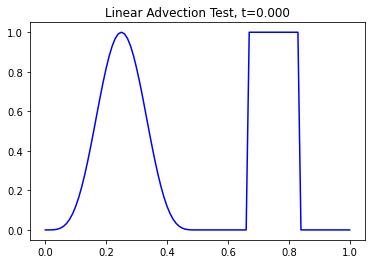

Hyperbolic linear advection, C=1
Uniform 101 node grid from 0.0 to 1.0.
Boundaries conditions are - left: Periodic, right: Periodic.
Initial conditions at t=0.0, Δt=0.009 seconds


In [2]:
def u_init(x):
    ''' Function to set the initial conditions for the test.
    x is a real number
    we return u(x)'''
    
    if x<0.5:
        u0 = np.sin(2*np.pi*x)**4
    elif x>=0.66667 and x<=0.83333:
        u0 = 1.0
    else:
        u0 = 0.0
    return u0

test = Grid(101)
test.generate()
test.set_Delta_t(0.9)
test.set_periodic_bc('right')
test.set_periodic_bc('left')
test.initial_conditions(u_init)
test.plot('Linear Advection Test')
print(test)


## The FOU Scheme
Using a first order upwind difference approximation for $\delta_x=$
  and ignoring $\delta_{xx}$, i.e.
$$\delta_x.u_i^n=\frac{u_{i}^n-u_{i-1}^n}{\Delta x}\mbox{ and }\delta_{xx}.u_i^n=0,$$

gives
$$u_i^{n+1}=u_i^n-\frac{C\Delta t}{\Delta x}\left(u_{i}^n-u_{i-1}^n\right),$$

which is the First Order Upwind (FOU) scheme.




Integrating from 0 to 0.009 seconds Δt=0.009 :. 


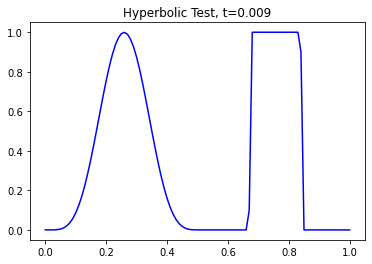

Integrating from 0.009 to 0.5 seconds Δt=0.009 :##########. 


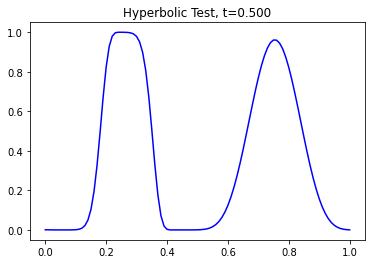

Integrating from 0.5 to 1 seconds Δt=0.009 :##########. 


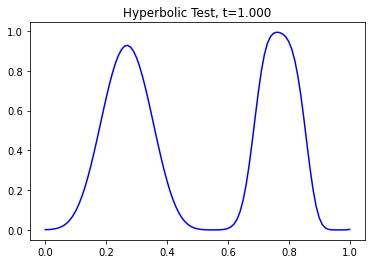

Hyperbolic linear advection, C=1
Uniform 101 node grid from 0.0 to 1.0.
Boundaries conditions are - left: Periodic, right: Periodic.
21 steps from t=0.0 to t=0.18, Δt=0.009 seconds


In [3]:
def FOU(grid):
    '''perform one time step using the FOU scheme on the hyperbolic 
    problem defined by grid. We are using whole array opperations
    for speed.'''
    Rx = grid.C*grid.Delta_t/grid.Delta_x()
    u = grid.u[-1].copy()
    u[1:-1]=u[1:-1]-Rx*(u[1:-1]-u[0:-2])
    return u


# Let's do one time step
test.integrate(test.Delta_t, FOU)
test.plot('Hyperbolic Test')

# Let's do half a revolution
test.integrate(0.5, FOU)
test.plot('Hyperbolic Test')

# and the last half a revolution
test.integrate(1.0, FOU)
test.plot('Hyperbolic Test')
print(test)


### X-t plot
Because we have stored every time step, we can plot a contour plot of the solution with time on one axis and space on the other.  To do this we must:
1. create a <code>meshgrid</code> using _x_ and _t_
2. plot the contour plot
3. add a colour bar
4. add titles and captions


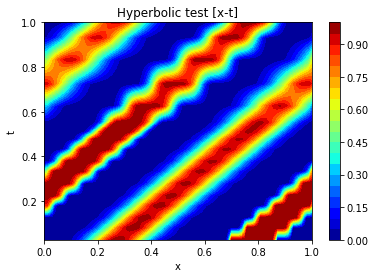

In [4]:
X,T = np.meshgrid(test.x,test.t)
fig, ax1 = plt.subplots()
cmap = plt.get_cmap('jet')
cf = ax1.contourf(X,T,test.u,cmap=cmap, levels = 21)
fig.colorbar(cf, ax=ax1)
ax1.set_title('Hyperbolic test [x-t]')
ax1.set_xlabel('x')
ax1.set_ylabel('t')
plt.show()


### Analysis

The _x_-_t_ plot shows the expected behaviour with the amplitude of the oscilation decaying as time increases.

We can compare the solution with the analytical one as well


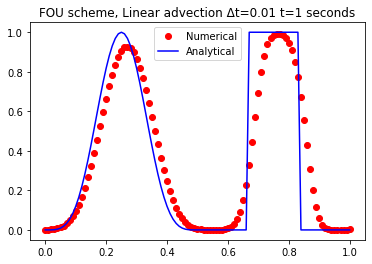

In [5]:
# construct the analytical solution
u_exact = []
for x_i in test.x:
    u_exact.append(u_init(x_i))

plt.plot(test.x,test.u[-1],'ro',label='Numerical')
plt.plot(test.x,u_exact,'b-',label='Analytical')
plt.title('FOU scheme, Linear advection Δt={:.3g} t={:.3g} seconds'.format(test.Delta_x(),test.t[-1]))
plt.legend()
plt.show()

We can see that the square wave has lost it's shape and the $\sin^4(x)$ wave has lost amplitude, and there is a small phase error.  We can try one of the higher order schemes to fix this.

## Lax-Wendroff Scheme

Peter Lax and Burton Wendroff designed a scheme based on using 2nd
order central difference approximations for both $\delta_x$ and
$\delta_{xx}$, i.e.

$$\delta_x.u_i^n=\frac{u_{i+1}^n-u_{i-1}^n}{2\Delta x}\mbox{ and }
\delta_{xx}.u_i^n=\frac{c_{i+1}^n-2u_i^n+u_{i-1}^n}{\Delta x^2}.$$ 

These choices lead to the so-called \textcolor{red}{Lax-Wendroff} scheme,

$$
u_i^{n+1}=u_i^n-\frac{C\Delta t}{2\Delta x}\left(u_{i+1}^n-u_{i-1}^n\right)
+\frac{C^2\Delta t^2}{2\Delta x^2}\left(u_{i+1}^n-2u_i^n+u_{i-1}^n\right),
$$



Integrating from 0 to 0.009 seconds Δt=0.009 :. 


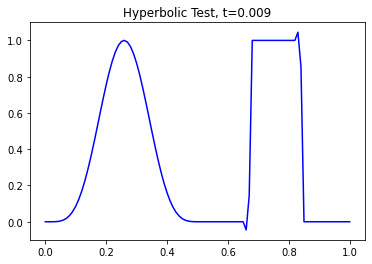

Integrating from 0.009 to 1 seconds Δt=0.009 :##########. 
Hyperbolic linear advection, C=1
Uniform 101 node grid from 0.0 to 1.0.
Boundaries conditions are - left: Periodic, right: Periodic.
11 steps from t=0.0 to t=0.09, Δt=0.009 seconds


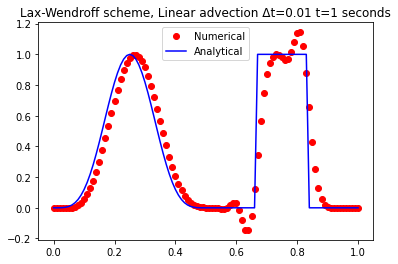

In [6]:
def Lax_Wendroff(grid):
    '''perform one time step using the Lax-Wendroff scheme on the 
    hyperbolic  problem defined by grid. We are using whole array 
    opperations for speed.'''
    Rx = grid.C*grid.Delta_t/(2*grid.Delta_x())
    Rx2 = grid.C**2*grid.Delta_t**2/(2*grid.Delta_x()**2)
    u = grid.u[-1].copy()
    u[1:-1]=u[1:-1]-Rx*(u[2:]-u[0:-2])+Rx2*(u[0:-2]-2*u[1:-1]+u[2:])
    return u


test2 = Grid(101)
test2.generate()
test2.set_Delta_t(0.9)
test2.set_periodic_bc('right')
test2.set_periodic_bc('left')
test2.initial_conditions(u_init)

# Let's do one time step
test2.integrate(test.Delta_t, Lax_Wendroff)
test2.plot('Hyperbolic Test')

# and the last half a revolution
test2.integrate(1.0, Lax_Wendroff)
print(test2)

plt.plot(test2.x,test2.u[-1],'ro',label='Numerical')
plt.plot(test2.x,u_exact,'b-',label='Analytical')
plt.title('Lax-Wendroff scheme, Linear advection Δt={:.3g} t={:.3g} seconds'.format(test.Delta_x(),test.t[-1]))
plt.legend()
plt.show()


We see better resolution of the $\sin^4$ wave without a loss of amplitude and better capture of the discontinuities, but we have Gibbs oscilations arounf the discontiuities.

### Mesh refinement 
Lets look at what happens if we use a much finer grid



Integrating from 0 to 1 seconds Δt=0.0009 :##########. 


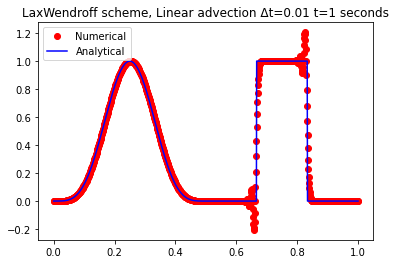

In [7]:
test3 = Grid(1001)
test3.generate()
test3.set_Delta_t(0.9)
test3.set_periodic_bc('right')
test3.set_periodic_bc('left')
test3.initial_conditions(u_init)
test3.integrate(1.0, Lax_Wendroff)

# construct the analytical solution
u3_exact = []
for x_i in test3.x:
    u3_exact.append(u_init(x_i))

plt.plot(test3.x,test3.u[-1],'ro',label='Numerical')
plt.plot(test3.x,u3_exact,'b-',label='Analytical')
plt.title('LaxWendroff scheme, Linear advection Δt={:.3g} t={:.3g} seconds'.format(test.Delta_x(),test.t[-1]))
plt.legend()
plt.show()




Integrating from 1 to 50 seconds Δt=0.0009 :##########. 
Integrating from 0 to 50 seconds Δt=0.0009 :##########. 


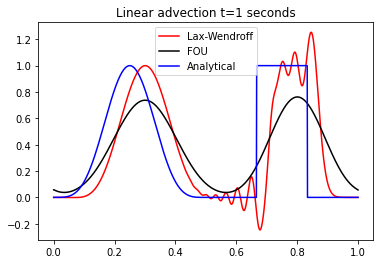

In [8]:
# not bad, lets try 50 cycles and compare with the FOU scheme
test3.integrate(50.0, Lax_Wendroff)

test4 = Grid(1001)
test4.generate()
test4.set_Delta_t(0.9)
test4.set_periodic_bc('right')
test4.set_periodic_bc('left')
test4.initial_conditions(u_init)
test4.integrate(50.0, FOU)

plt.plot(test3.x,test3.u[-1],'r-',label='Lax-Wendroff')
plt.plot(test4.x,test4.u[-1],'k-',label='FOU')
plt.plot(test3.x,u3_exact,'b-',label='Analytical')
plt.title('Linear advection t={:.3g} seconds'.format(test.t[-1]))
plt.legend()
plt.show()



### Analysis
Both schemes seem to have the same phase error and the solution is shifted to the right of where we expect it to be.  This should not happen and points to a bug in the code, proably related to the periodic boundary conditions.  However, the First Order Upwind (FOU) scheme gives almost the same profiule for both the step and the Gaussian hump and both have lost a lot of amplitude.  The Lax Wendroff shcheme shows a tiny loss of amplitude on the Gaussian hump and good resolution of the shock waves, though with large Gibbs oscilations present.  

To remove these we will need to make use of TVD schemes.

The Grid class for hyperbolic problems can be used to test a range of other advection schemes quickly and efficiently and we will use it again to look at TVD schemes.